In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import joblib
from datetime import datetime
import optuna

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

print("All libraries imported.")

All libraries imported.


In [2]:
splits_dir = "../data/splits"
train_path = os.path.join(splits_dir, "train.csv")
val_path = os.path.join(splits_dir, "validation.csv")
test_path = os.path.join(splits_dir, "test.csv")

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

Train set: (3460, 44)
Validation set: (742, 44)
Test set: (742, 44)


In [3]:
target_col = 'price'
feature_cols = [col for col in train_df.columns if col != target_col]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Number of features: {len(feature_cols)}")

Number of features: 43


In [4]:
train_sorted = train_df.copy()
train_sorted = train_sorted.sort_values(['week_num', 'vegetable']).reset_index(drop=True)

X_train_sorted = train_sorted[feature_cols]
y_train_sorted = train_sorted[target_col]

print("Training data sorted by week_num and vegetable.")

Training data sorted by week_num and vegetable.


In [5]:
tscv = TimeSeriesSplit(n_splits=3)  # 3 splits = 4 folds, but we'll use 3 train/val pairs
print(f"TimeSeriesSplit will create {tscv.get_n_splits()} train/validation splits.")

TimeSeriesSplit will create 3 train/validation splits.


In [6]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """Calculate metrics on train, validation, and test sets."""
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    metrics = {
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Validation RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Validation MAE': val_mae,
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'Validation R2': val_r2,
        'Test R2': test_r2
    }

    print(f"\n{model_name} – Test RMSE: {test_rmse:.4f}, Test R2: {test_r2:.4f}")
    return metrics, y_train_pred, y_val_pred, y_test_pred

In [7]:
def xgb_objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.03, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 30, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 30, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'gamma': trial.suggest_float('gamma', 0.1, 1.0),
        'n_estimators': 500,
        'random_state': 42,
        'objective': 'reg:squarederror',
        'early_stopping_rounds': 10
    }

    model = xgb.XGBRegressor(**params)

    rmse_scores = []
    for train_idx, val_idx in tscv.split(X_train_sorted):
        X_tr = X_train_sorted.iloc[train_idx]
        y_tr = y_train_sorted.iloc[train_idx]
        X_cv_val = X_train_sorted.iloc[val_idx]
        y_cv_val = y_train_sorted.iloc[val_idx]

        model.fit(X_tr, y_tr,
                  eval_set=[(X_cv_val, y_cv_val)],
                  verbose=False)
        pred = model.predict(X_cv_val)
        rmse = np.sqrt(mean_squared_error(y_cv_val, pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

print("Running Optuna for XGBoost...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=30, show_progress_bar=True)

print(f"\nBest XGBoost params: {study_xgb.best_params}")
print(f"Best CV RMSE: {study_xgb.best_value:.4f}")

[I 2026-02-16 15:51:59,640] A new study created in memory with name: no-name-49652806-2b94-4ac1-b665-591df53edbf7


Running Optuna for XGBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-02-16 15:52:00,808] Trial 0 finished with value: 50.822905261510975 and parameters: {'max_depth': 2, 'learning_rate': 0.016786518899961498, 'subsample': 0.5590406010002619, 'colsample_bytree': 0.5405789488313449, 'reg_alpha': 1.2471707468881859, 'reg_lambda': 1.0222883758241614, 'min_child_weight': 11, 'gamma': 0.45237523975103056}. Best is trial 0 with value: 50.822905261510975.
[I 2026-02-16 15:52:02,464] Trial 1 finished with value: 44.31275477108344 and parameters: {'max_depth': 5, 'learning_rate': 0.02281187642446217, 'subsample': 0.7008111187985644, 'colsample_bytree': 0.7021545458350791, 'reg_alpha': 18.14938076695522, 'reg_lambda': 14.595959464035012, 'min_child_weight': 7, 'gamma': 0.16761468701609403}. Best is trial 1 with value: 44.31275477108344.
[I 2026-02-16 15:52:03,580] Trial 2 finished with value: 53.365248888426855 and parameters: {'max_depth': 2, 'learning_rate': 0.008852956686765641, 'subsample': 0.7967468849081745, 'colsample_bytree': 0.5038525177310469, 'r

In [8]:
best_xgb_params = study_xgb.best_params.copy()
best_xgb_params['n_estimators'] = 500
best_xgb_params['random_state'] = 42
best_xgb_params['objective'] = 'reg:squarederror'
best_xgb_params['early_stopping_rounds'] = 10

xgb_tuned = xgb.XGBRegressor(**best_xgb_params)

# Combine train and validation for final training
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Fit with eval_set to get learning curves
xgb_tuned.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

xgb_metrics, xgb_train_pred, xgb_val_pred, xgb_test_pred = evaluate_model(
    xgb_tuned, X_train, y_train, X_val, y_val, X_test, y_test, "XGBoost (Tuned)"
)

models = {'XGBoost (Tuned)': xgb_tuned}


XGBoost (Tuned) – Test RMSE: 29.9932, Test R2: 0.8912


In [9]:
def lgb_objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.03, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 30, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 30, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'n_estimators': 500,
        'random_state': 42,
        'verbosity': -1
    }

    model = lgb.LGBMRegressor(**params)

    rmse_scores = []
    for train_idx, val_idx in tscv.split(X_train_sorted):
        X_tr = X_train_sorted.iloc[train_idx]
        y_tr = y_train_sorted.iloc[train_idx]
        X_cv_val = X_train_sorted.iloc[val_idx]
        y_cv_val = y_train_sorted.iloc[val_idx]

        model.fit(X_tr, y_tr,
                  eval_set=[(X_cv_val, y_cv_val)],
                  eval_metric='rmse',
                  callbacks=[lgb.early_stopping(10)])
        pred = model.predict(X_cv_val)
        rmse = np.sqrt(mean_squared_error(y_cv_val, pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

print("Running Optuna for LightGBM...")
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(lgb_objective, n_trials=30, show_progress_bar=True)

print(f"\nBest LightGBM params: {study_lgb.best_params}")
print(f"Best CV RMSE: {study_lgb.best_value:.4f}")

[I 2026-02-16 15:52:43,329] A new study created in memory with name: no-name-dfc77498-13b9-47e6-8553-f8f3a8e79aef


Running Optuna for LightGBM...


  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[244]	valid_0's rmse: 56.1495	valid_0's l2: 3152.77
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[256]	valid_0's rmse: 39.6812	valid_0's l2: 1574.6
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 40.4641	valid_0's l2: 1637.34
[I 2026-02-16 15:52:43,973] Trial 0 finished with value: 45.43160876178079 and parameters: {'num_leaves': 34, 'max_depth': 6, 'learning_rate': 0.022296962337364355, 'subsample': 0.506451662177192, 'colsample_bytree': 0.6299417286713695, 'reg_alpha': 3.2578947454902334, 'reg_lambda': 12.537595860950637, 'min_child_samples': 71}. Best is trial 0 with value: 45.43160876178079.
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[232]	valid_0's rmse: 56.1793	valid_0's l2: 3156.12
Training until vali

In [10]:
best_lgb_params = study_lgb.best_params.copy()
best_lgb_params['n_estimators'] = 500
best_lgb_params['random_state'] = 42
best_lgb_params['verbosity'] = -1

lgb_tuned = lgb.LGBMRegressor(**best_lgb_params)

lgb_tuned.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(10)]
)

lgb_metrics, lgb_train_pred, lgb_val_pred, lgb_test_pred = evaluate_model(
    lgb_tuned, X_train, y_train, X_val, y_val, X_test, y_test, "LightGBM (Tuned)"
)

models['LightGBM (Tuned)'] = lgb_tuned

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 27.5991	valid_0's l2: 761.712	valid_1's rmse: 25.6504	valid_1's l2: 657.942

LightGBM (Tuned) – Test RMSE: 30.2234, Test R2: 0.8895


In [11]:
def cb_objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.03, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 30, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 3),
        'border_count': trial.suggest_int('border_count', 32, 64),
        'iterations': 500,
        'random_seed': 42,
        'early_stopping_rounds': 10,
        'verbose': False
    }

    model = cb.CatBoostRegressor(**params)

    rmse_scores = []
    for train_idx, val_idx in tscv.split(X_train_sorted):
        X_tr = X_train_sorted.iloc[train_idx]
        y_tr = y_train_sorted.iloc[train_idx]
        X_cv_val = X_train_sorted.iloc[val_idx]
        y_cv_val = y_train_sorted.iloc[val_idx]

        model.fit(X_tr, y_tr, eval_set=(X_cv_val, y_cv_val), verbose=False)
        pred = model.predict(X_cv_val)
        rmse = np.sqrt(mean_squared_error(y_cv_val, pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

print("Running Optuna for CatBoost...")
study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(cb_objective, n_trials=30, show_progress_bar=True)

print(f"\nBest CatBoost params: {study_cb.best_params}")
print(f"Best CV RMSE: {study_cb.best_value:.4f}")

[I 2026-02-16 15:53:02,930] A new study created in memory with name: no-name-c5dc8831-5b6c-4537-905b-04f7b4b3dec4


Running Optuna for CatBoost...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-02-16 15:53:05,785] Trial 0 finished with value: 56.93992755364757 and parameters: {'depth': 6, 'learning_rate': 0.00882225194250282, 'l2_leaf_reg': 20.40728022904407, 'bagging_temperature': 2.3597096483806483, 'border_count': 51}. Best is trial 0 with value: 56.93992755364757.
[I 2026-02-16 15:53:06,982] Trial 1 finished with value: 47.54605096253402 and parameters: {'depth': 4, 'learning_rate': 0.029605454579703573, 'l2_leaf_reg': 5.083265352283233, 'bagging_temperature': 0.641549361427738, 'border_count': 50}. Best is trial 1 with value: 47.54605096253402.
[I 2026-02-16 15:53:08,249] Trial 2 finished with value: 51.61932674098145 and parameters: {'depth': 4, 'learning_rate': 0.02812051411540472, 'l2_leaf_reg': 23.68294890366224, 'bagging_temperature': 1.6461929107815894, 'border_count': 33}. Best is trial 1 with value: 47.54605096253402.
[I 2026-02-16 15:53:10,933] Trial 3 finished with value: 52.22106302727055 and parameters: {'depth': 6, 'learning_rate': 0.0069121965266472

In [12]:
best_cb_params = study_cb.best_params.copy()
best_cb_params['iterations'] = 500
best_cb_params['random_seed'] = 42
best_cb_params['early_stopping_rounds'] = 10
best_cb_params['verbose'] = False

cb_tuned = cb.CatBoostRegressor(**best_cb_params)

# CatBoost accepts eval_set as a list of tuples
cb_tuned.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train, y_train), (X_val, y_val)]
)

cb_metrics, cb_train_pred, cb_val_pred, cb_test_pred = evaluate_model(
    cb_tuned, X_train, y_train, X_val, y_val, X_test, y_test, "CatBoost (Tuned)"
)

models['CatBoost (Tuned)'] = cb_tuned


CatBoost (Tuned) – Test RMSE: 37.5400, Test R2: 0.8296


In [13]:
metrics_list = [xgb_metrics, lgb_metrics, cb_metrics]
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Model', inplace=True)

print("\n" + "="*60)
print("TUNED MODELS COMPARISON (TEST SET)")
print("="*60)
print(metrics_df[['Test RMSE', 'Test MAE', 'Test R2']].round(4))

best_model_name = metrics_df['Test RMSE'].idxmin()
print(f"\n🏆 Best model by Test RMSE: {best_model_name}")


TUNED MODELS COMPARISON (TEST SET)
                  Test RMSE  Test MAE  Test R2
Model                                         
XGBoost (Tuned)     29.9932   20.8737   0.8912
LightGBM (Tuned)    30.2234   20.9762   0.8895
CatBoost (Tuned)    37.5400   27.1943   0.8296

🏆 Best model by Test RMSE: XGBoost (Tuned)


LightGBM evals_result_ keys: dict_keys(['valid_0', 'valid_1'])
CatBoost evals_result keys: dict_keys(['learn', 'validation_0', 'validation_1'])


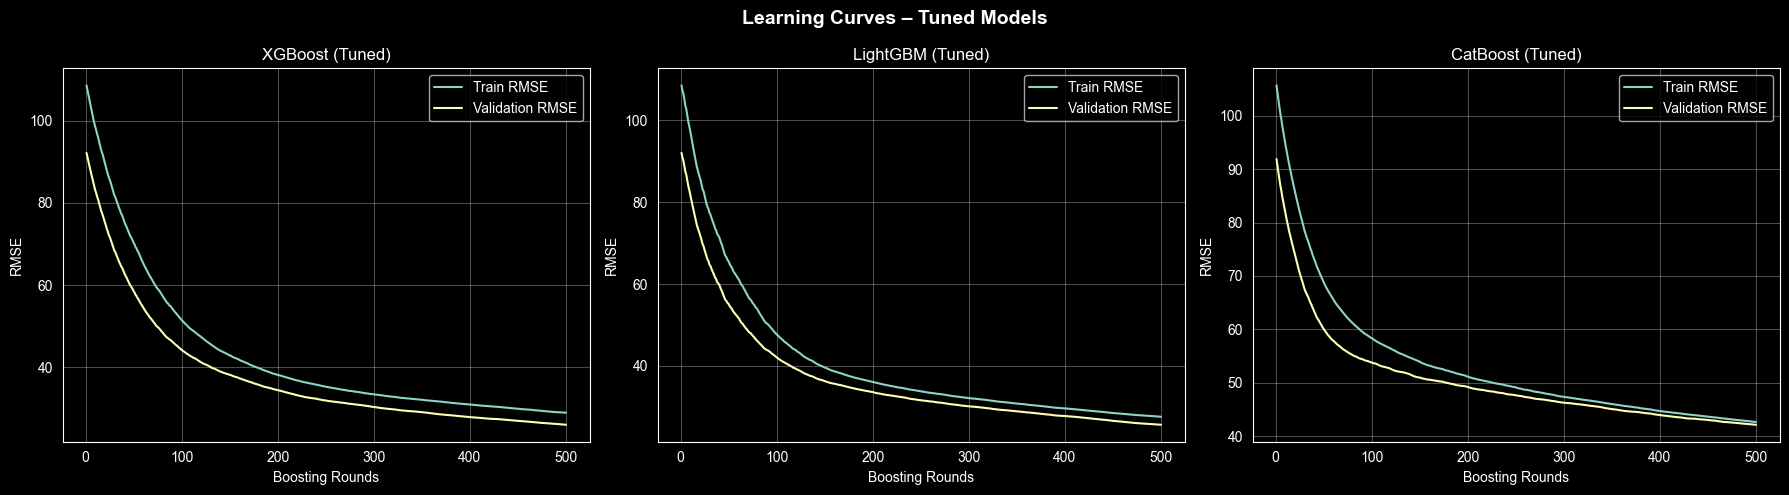

In [14]:
# XGBoost
xgb_results = xgb_tuned.evals_result()
xgb_train_rmse = xgb_results['validation_0']['rmse']
xgb_val_rmse = xgb_results['validation_1']['rmse']

# LightGBM
lgb_results = lgb_tuned.evals_result_
print("LightGBM evals_result_ keys:", lgb_results.keys())
# We expect 'valid_0' (training) and 'valid_1' (validation)
lgb_train_rmse = lgb_results['valid_0']['rmse']
lgb_val_rmse = lgb_results['valid_1']['rmse']

# CatBoost
cb_results = cb_tuned.get_evals_result()
print("CatBoost evals_result keys:", cb_results.keys())
# We expect 'learn' (training) and 'validation_1' (validation)
cb_train_rmse = cb_results['learn']['RMSE']
cb_val_rmse = cb_results['validation_1']['RMSE']   # because we passed two eval sets

# Plot learning curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_learning_curve(ax, train_err, val_err, title):
    epochs = range(1, len(train_err)+1)
    ax.plot(epochs, train_err, label='Train RMSE')
    ax.plot(epochs, val_err, label='Validation RMSE')
    ax.set_title(title)
    ax.set_xlabel('Boosting Rounds')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True, alpha=0.3)

plot_learning_curve(axes[0], xgb_train_rmse, xgb_val_rmse, 'XGBoost (Tuned)')
plot_learning_curve(axes[1], lgb_train_rmse, lgb_val_rmse, 'LightGBM (Tuned)')
plot_learning_curve(axes[2], cb_train_rmse, cb_val_rmse, 'CatBoost (Tuned)')

plt.suptitle('Learning Curves – Tuned Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

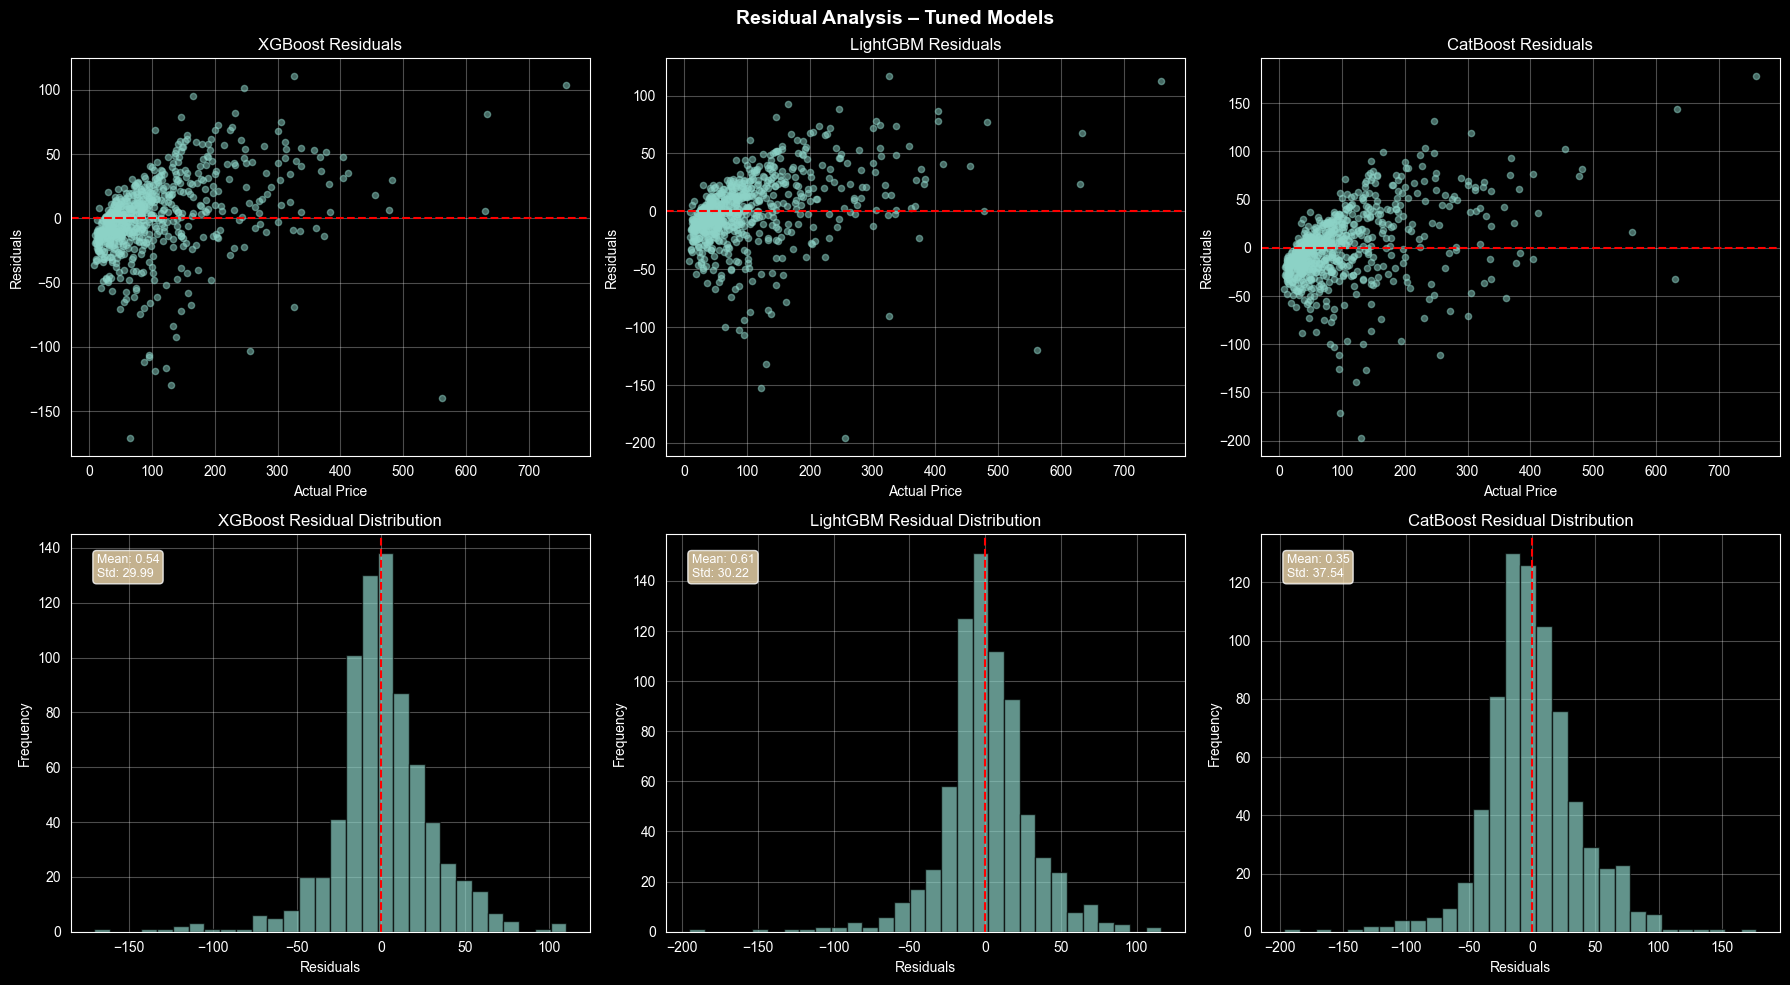

In [15]:
residuals = {
    'XGBoost': y_test - xgb_test_pred,
    'LightGBM': y_test - lgb_test_pred,
    'CatBoost': y_test - cb_test_pred
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (name, resid) in enumerate(residuals.items()):
    # Scatter plot
    ax = axes[0, i]
    ax.scatter(y_test, resid, alpha=0.5, s=20)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'{name} Residuals')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Residuals')
    ax.grid(True, alpha=0.3)

    # Histogram
    ax = axes[1, i]
    ax.hist(resid, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'{name} Residual Distribution')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

    mean_resid = np.mean(resid)
    std_resid = np.std(resid)
    ax.text(0.05, 0.95, f'Mean: {mean_resid:.2f}\nStd: {std_resid:.2f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Residual Analysis – Tuned Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

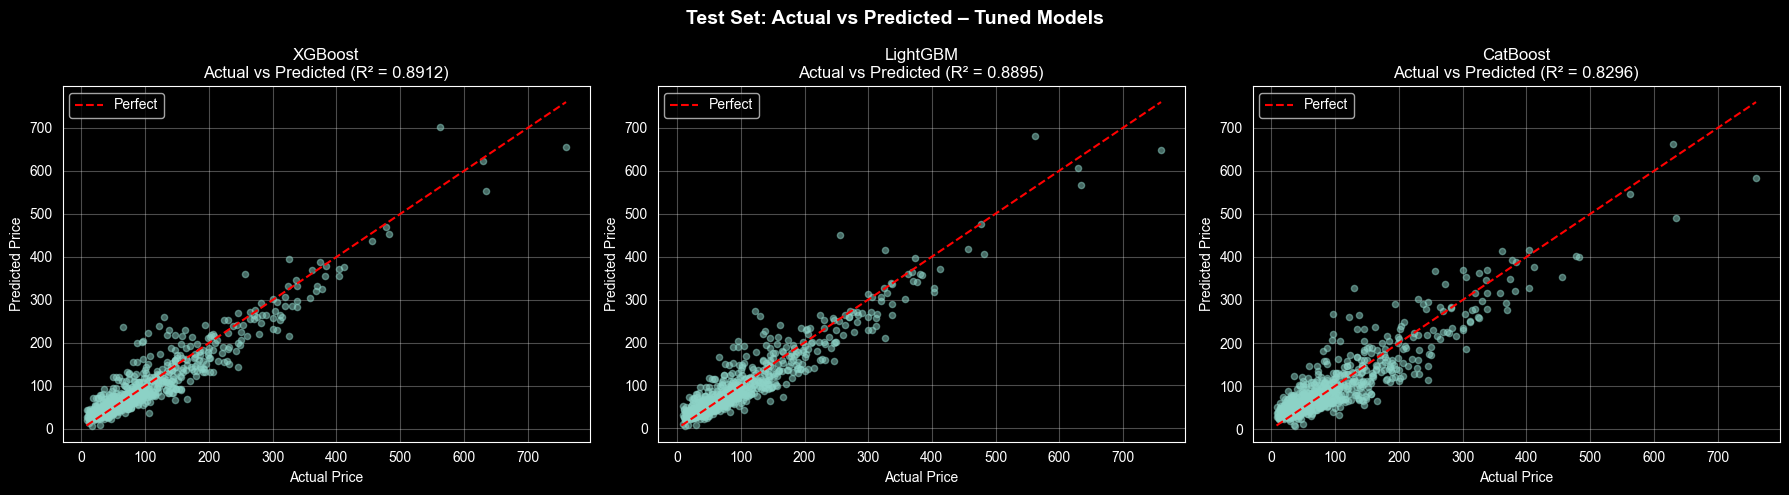

In [16]:
predictions = {
    'XGBoost': xgb_test_pred,
    'LightGBM': lgb_test_pred,
    'CatBoost': cb_test_pred
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, pred) in zip(axes, predictions.items()):
    ax.scatter(y_test, pred, alpha=0.5, s=20)
    min_val = min(y_test.min(), pred.min())
    max_val = max(y_test.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect')
    r2 = r2_score(y_test, pred)
    ax.set_title(f'{name}\nActual vs Predicted (R² = {r2:.4f})')
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Test Set: Actual vs Predicted – Tuned Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

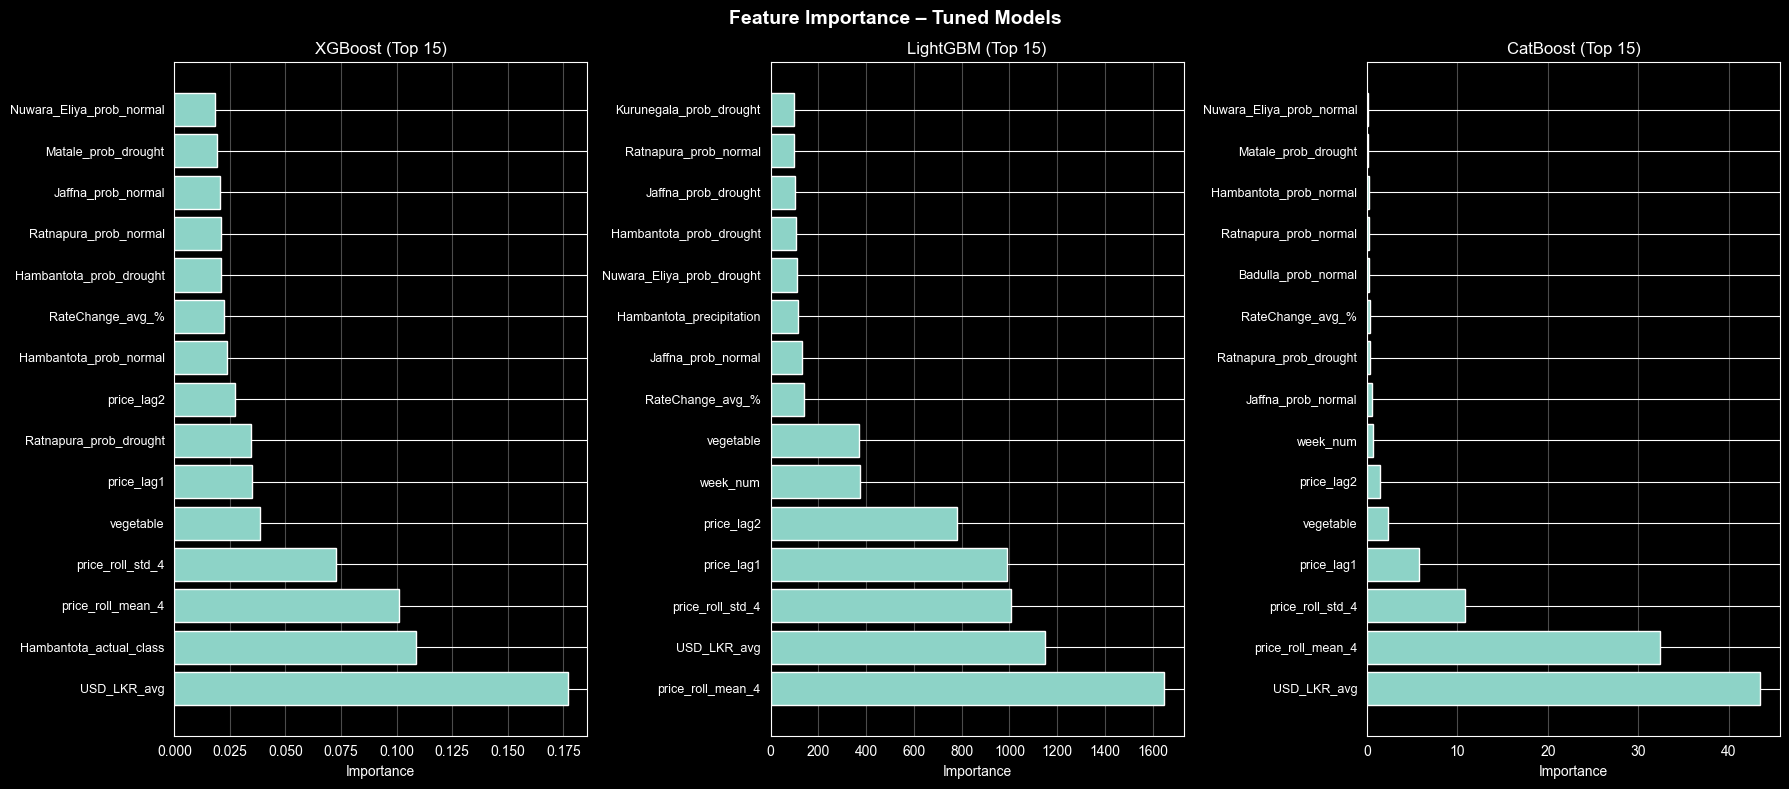

In [17]:
def plot_feature_importance(model, model_name, feature_names, ax):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-15:]
        top_features = [feature_names[i] for i in indices]
        top_importances = importances[indices]
        y_pos = np.arange(len(top_features))
        ax.barh(y_pos, top_importances, align='center')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features, fontsize=9)
        ax.invert_yaxis()
        ax.set_title(f'{model_name} (Top 15)')
        ax.set_xlabel('Importance')
        ax.grid(True, alpha=0.3, axis='x')
    else:
        ax.text(0.5, 0.5, 'No feature_importances_', ha='center')

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
plot_feature_importance(xgb_tuned, 'XGBoost', feature_cols, axes[0])
plot_feature_importance(lgb_tuned, 'LightGBM', feature_cols, axes[1])
plot_feature_importance(cb_tuned, 'CatBoost', feature_cols, axes[2])
plt.suptitle('Feature Importance – Tuned Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

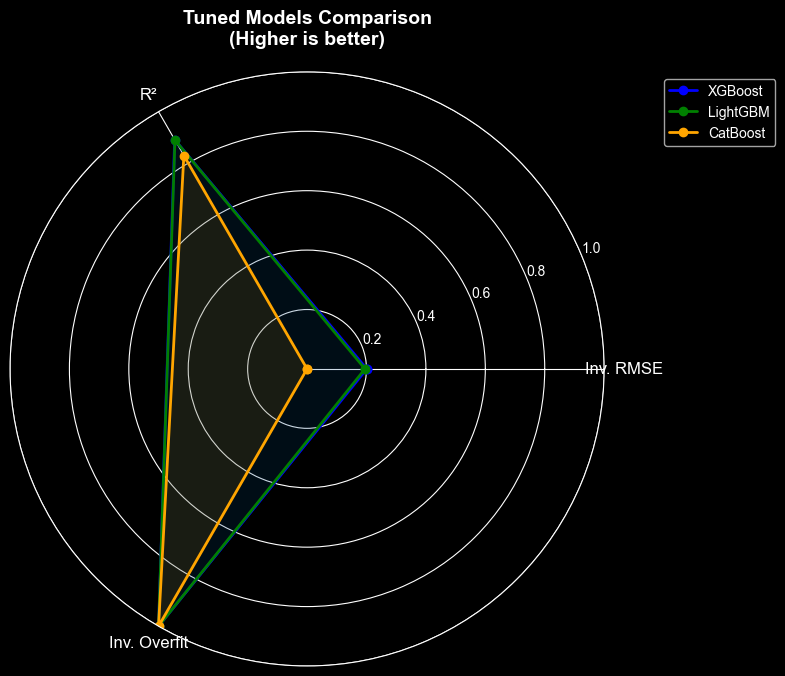

In [18]:
from math import pi

# Prepare three metrics: Test RMSE (inverted), Test R2, and Validation-Train gap (inverted as a proxy for overfitting)
xgb_gap = xgb_metrics['Validation RMSE'] - xgb_metrics['Train RMSE']
lgb_gap = lgb_metrics['Validation RMSE'] - lgb_metrics['Train RMSE']
cb_gap = cb_metrics['Validation RMSE'] - cb_metrics['Train RMSE']

# Normalize each metric to [0,1] where higher is better
max_rmse = max(xgb_metrics['Test RMSE'], lgb_metrics['Test RMSE'], cb_metrics['Test RMSE'])
max_gap = max(xgb_gap, lgb_gap, cb_gap)

xgb_norm = [
    1 - xgb_metrics['Test RMSE'] / max_rmse,
    xgb_metrics['Test R2'],
    1 - xgb_gap / max_gap if max_gap > 0 else 1.0
]
lgb_norm = [
    1 - lgb_metrics['Test RMSE'] / max_rmse,
    lgb_metrics['Test R2'],
    1 - lgb_gap / max_gap if max_gap > 0 else 1.0
]
cb_norm = [
    1 - cb_metrics['Test RMSE'] / max_rmse,
    cb_metrics['Test R2'],
    1 - cb_gap / max_gap if max_gap > 0 else 1.0
]

# Radar chart
categories = ['Inv. RMSE', 'R²', 'Inv. Overfit']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

xgb_norm += xgb_norm[:1]
lgb_norm += lgb_norm[:1]
cb_norm += cb_norm[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, xgb_norm, 'o-', linewidth=2, label='XGBoost', color='blue')
ax.fill(angles, xgb_norm, alpha=0.1, color='blue')
ax.plot(angles, lgb_norm, 'o-', linewidth=2, label='LightGBM', color='green')
ax.fill(angles, lgb_norm, alpha=0.1, color='green')
ax.plot(angles, cb_norm, 'o-', linewidth=2, label='CatBoost', color='orange')
ax.fill(angles, cb_norm, alpha=0.1, color='orange')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(0, 1)
ax.set_title('Tuned Models Comparison\n(Higher is better)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.tight_layout()
plt.show()

In [19]:
def assess_overfitting(train_rmse, val_rmse, test_rmse):
    val_gap = val_rmse - train_rmse
    test_gap = test_rmse - train_rmse
    val_gap_pct = (val_gap / train_rmse) * 100 if train_rmse != 0 else 0
    test_gap_pct = (test_gap / train_rmse) * 100 if train_rmse != 0 else 0
    avg_gap_pct = (val_gap_pct + test_gap_pct) / 2
    if avg_gap_pct < 5:
        return "LOW", "✅ Generalizes well"
    elif avg_gap_pct < 15:
        return "MODERATE", "⚠️ Some overfitting"
    else:
        return "HIGH", "❌ Significant overfitting"

def accuracy_rating(r2):
    if r2 >= 0.9:
        return "EXCELLENT", "🌟 Very high"
    elif r2 >= 0.8:
        return "GOOD", "👍 Good"
    elif r2 >= 0.6:
        return "FAIR", "⚡ Moderate"
    elif r2 >= 0.4:
        return "POOR", "⚠️ Low"
    else:
        return "VERY POOR", "❌ Poor"

model_details = []
for model_name, model in models.items():
    if 'XGBoost' in model_name:
        train_rmse = xgb_metrics['Train RMSE']
        val_rmse = xgb_metrics['Validation RMSE']
        test_rmse = xgb_metrics['Test RMSE']
        test_r2 = xgb_metrics['Test R2']
        test_mae = xgb_metrics['Test MAE']
    elif 'LightGBM' in model_name:
        train_rmse = lgb_metrics['Train RMSE']
        val_rmse = lgb_metrics['Validation RMSE']
        test_rmse = lgb_metrics['Test RMSE']
        test_r2 = lgb_metrics['Test R2']
        test_mae = lgb_metrics['Test MAE']
    else:
        train_rmse = cb_metrics['Train RMSE']
        val_rmse = cb_metrics['Validation RMSE']
        test_rmse = cb_metrics['Test RMSE']
        test_r2 = cb_metrics['Test R2']
        test_mae = cb_metrics['Test MAE']

    overfit_level, overfit_desc = assess_overfitting(train_rmse, val_rmse, test_rmse)
    acc_rating, acc_desc = accuracy_rating(test_r2)

    model_details.append({
        'Model': model_name,
        'Train RMSE': train_rmse,
        'Val RMSE': val_rmse,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Test R²': test_r2,
        'Overfitting Level': overfit_level,
        'Overfitting Desc': overfit_desc,
        'Accuracy Rating': acc_rating,
        'Accuracy Desc': acc_desc
    })

summary_df = pd.DataFrame(model_details)

print("="*80)
print("📊 TUNED MODELS – FINAL SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Composite score for best model selection
summary_df['RMSE_norm'] = 1 - (summary_df['Test RMSE'] / summary_df['Test RMSE'].max())
summary_df['R2_norm'] = summary_df['Test R²'] / summary_df['Test R²'].max()
overfit_map = {'LOW': 1.0, 'MODERATE': 0.6, 'HIGH': 0.2}
summary_df['Overfit_score'] = summary_df['Overfitting Level'].map(overfit_map)
summary_df['Composite'] = 0.4*summary_df['R2_norm'] + 0.3*summary_df['RMSE_norm'] + 0.3*summary_df['Overfit_score']

best_idx = summary_df['Composite'].idxmax()
best_model = summary_df.loc[best_idx]

print(f"\n🏆 BEST MODEL (composite): {best_model['Model']}")
print(f"   Test RMSE: {best_model['Test RMSE']:.4f}, Test R²: {best_model['Test R²']:.4f}")
print(f"   Overfitting: {best_model['Overfitting Level']}, Accuracy: {best_model['Accuracy Rating']}")

📊 TUNED MODELS – FINAL SUMMARY
           Model  Train RMSE  Val RMSE  Test RMSE  Test MAE  Test R² Overfitting Level   Overfitting Desc Accuracy Rating Accuracy Desc
 XGBoost (Tuned)   28.901844 25.959492  29.993215 20.873738 0.891196               LOW ✅ Generalizes well            GOOD        👍 Good
LightGBM (Tuned)   27.599133 25.650387  30.223430 20.976152 0.889519               LOW ✅ Generalizes well            GOOD        👍 Good
CatBoost (Tuned)   42.767747 42.130829  37.539993 27.194278 0.829554               LOW ✅ Generalizes well            GOOD        👍 Good

🏆 BEST MODEL (composite): XGBoost (Tuned)
   Test RMSE: 29.9932, Test R²: 0.8912
   Overfitting: LOW, Accuracy: GOOD


In [20]:
models_dir = "../models/tuned_models"
os.makedirs(models_dir, exist_ok=True)

for model_name, model in models.items():
    safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()
    filename = f"{safe_name}.joblib"
    joblib.dump(model, os.path.join(models_dir, filename))
    print(f"✅ Saved: {filename}")

metadata = summary_df[['Model', 'Test RMSE', 'Test MAE', 'Test R²', 'Overfitting Level', 'Accuracy Rating']].copy()
metadata['Best_Model'] = best_model['Model']
metadata['Generated'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
metadata.to_csv(os.path.join(models_dir, 'model_metadata.csv'), index=False)
print(f"✅ Saved model metadata")
print(f"\n📁 All tuned models saved to: {os.path.abspath(models_dir)}")

✅ Saved: xgboost_tuned.joblib
✅ Saved: lightgbm_tuned.joblib
✅ Saved: catboost_tuned.joblib
✅ Saved model metadata

📁 All tuned models saved to: C:\Users\Arosha IIT\OneDrive - Robert Gordon University\Desktop\DSGP\DSGP_Group_38\WholeSale-Price-Model\models\tuned_models
